In [161]:
using Plots, StatsPlots, Plots.PlotMeasures
using StatsBase
using Random
using JLD2
using Distributions
using Normalization

# Trial One - Low Noise Setting

In [61]:
samps = sample([-0.8, 0.0, 0.8], ProbabilityWeights([1/3, 1/3, 1/3]), 1000);

In [63]:
# specify distributions over parameters
phase_dist = Uniform(0, 2pi)
sigma_dist = 0.1 # noise standard deviation
freq_dist = [5.0, 20.0]
trend_dist = [-0.8, 0.0, 0.8];

In [363]:
function simulate_noisy_sine(T::Int, freq::Float64, phase::Float64,
    trend::Float64, sigma::Float64)

    x = collect(range(0, freq*pi, T))
    signal_component = 1.0 * sin.(2 * x .+ phase)
    noise_component = rand(Normal(0, sigma), T)
    trend_component = trend .* x
    noisy_sine = signal_component + noise_component + trend_component

    return noisy_sine

end;

In [388]:
function make_dataset(num_train::Int, num_test::Int, 
    T::Int)

    train_matrix = Matrix{Float64}(undef, num_train, T)
    train_labels = Int.(zeros(num_train))
    test_matrix = Matrix{Float64}(undef, num_test, T)
    test_labels = Int.(zeros(num_test))


    phase_train = rand(Uniform(0, 2pi), num_train)
    phase_test = rand(Uniform(0, 2pi), num_test)
    sigma_train = fill(0.1, num_train)
    sigma_test = fill(0.1, num_test)
    freq_train = sample([3.0, 6.0], ProbabilityWeights([1/2, 1/2]), num_train)
    freq_test = sample([3.0, 6.0], ProbabilityWeights([1/2, 1/2]), num_test)
    trend_train = sample([-0.25, 0.0, 0.25], ProbabilityWeights([1/3, 1/3, 1/3]), num_train)
    trend_test = sample([-0.25, 0.0, 0.25], ProbabilityWeights([1/3, 1/3, 1/3]), num_test)
    train_info = Dict(
        "phase" => phase_train,
        "sigma" => sigma_train,
        "freq" => freq_train,
        "trend" => trend_train
    )
    test_info = Dict(
        "phase" => phase_test,
        "sigma" => sigma_test,
        "freq" => freq_test,
        "trend" => trend_test
    )
    
    for i in 1:num_train
        x = simulate_noisy_sine(100, freq_train[i], phase_train[i], trend_train[i], sigma_train[i])
        train_matrix[i, :] = x
    end

    for j in 1:num_test
        x = simulate_noisy_sine(100, freq_test[j], phase_test[j], trend_test[j], sigma_test[j])
        test_matrix[j, :] = x
    end

    X_train = train_matrix
    y_train = train_labels
    X_test = test_matrix
    y_test = test_labels

    return X_train, y_train, X_test, y_test, train_info, test_info

end

make_dataset (generic function with 1 method)

In [389]:
X_train, y_train, X_test, y_test, train_info, test_info = make_dataset(1000, 200, 100)

([0.9469000933365477 0.8308970272122895 … -3.772242218116361 -3.8144159398069704; -0.972614866319506 -0.5912859011953594 … 1.4056486327610083 1.5603415267433234; … ; -0.6288143884586098 -0.17903547672651612 … 3.732234885996017 4.082047681699276; -0.7824886149448459 -0.9453026082158903 … -0.5654573374579219 -0.6311430244655021], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.7227634999431494 0.9988343356528226 … 5.598333758778054 5.661953613738667; 0.38512790276369335 -0.16039955502845138 … -4.074393047337299 -4.4380263974263; … ; -0.9406536765758373 -1.1023423464312432 … 3.8266171988740383 3.65628230646434; -0.5028649011830542 -0.5001678120666638 … -2.602032383021648 -2.79945511176324], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Dict("sigma" => [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], "phase" => [1.8748924297100145, 5.181861866380056, 0.9831837184045046, 6.236634684779415, 4.03096

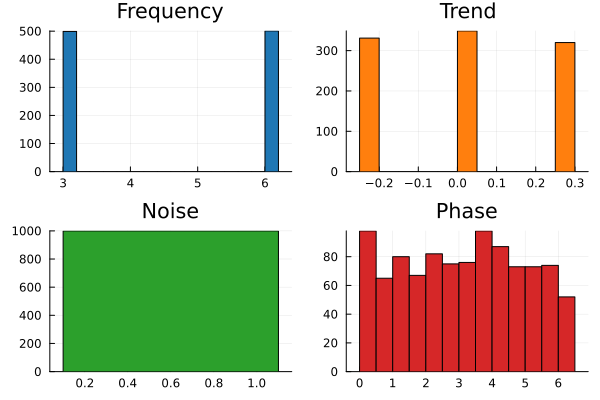

In [398]:
h1 = histogram(train_info["freq"], bins=20, label="", c=palette(:tab10)[1], title="Frequency")
h2 = histogram(train_info["trend"], bins=20, label="", c=palette(:tab10)[2], title="Trend")
h3 = histogram(train_info["sigma"], bins=20, label="", c=palette(:tab10)[3], title="Noise")
h4 = histogram(train_info["phase"], bins=20, label="", c=palette(:tab10)[4], title="Phase")
plot(h1, h2, h3, h4)
#savefig("noisy_sine_dist3.svg")

In [391]:
rs = RobustSigmoid(X_train)
rs_scaled = rs(X_train);

In [392]:
trend_map = Dict(
    0.25 => palette(:tab10)[1],
    0.0 => palette(:tab10)[2],
    -0.25 => palette(:tab10)[3]
)

Dict{Float64, RGB{Float64}} with 3 entries:
  0.0   => RGB{Float64}(1.0,0.498,0.0549)
  -0.25 => RGB{Float64}(0.1725,0.6275,0.1725)
  0.25  => RGB{Float64}(0.1216,0.4667,0.7059)

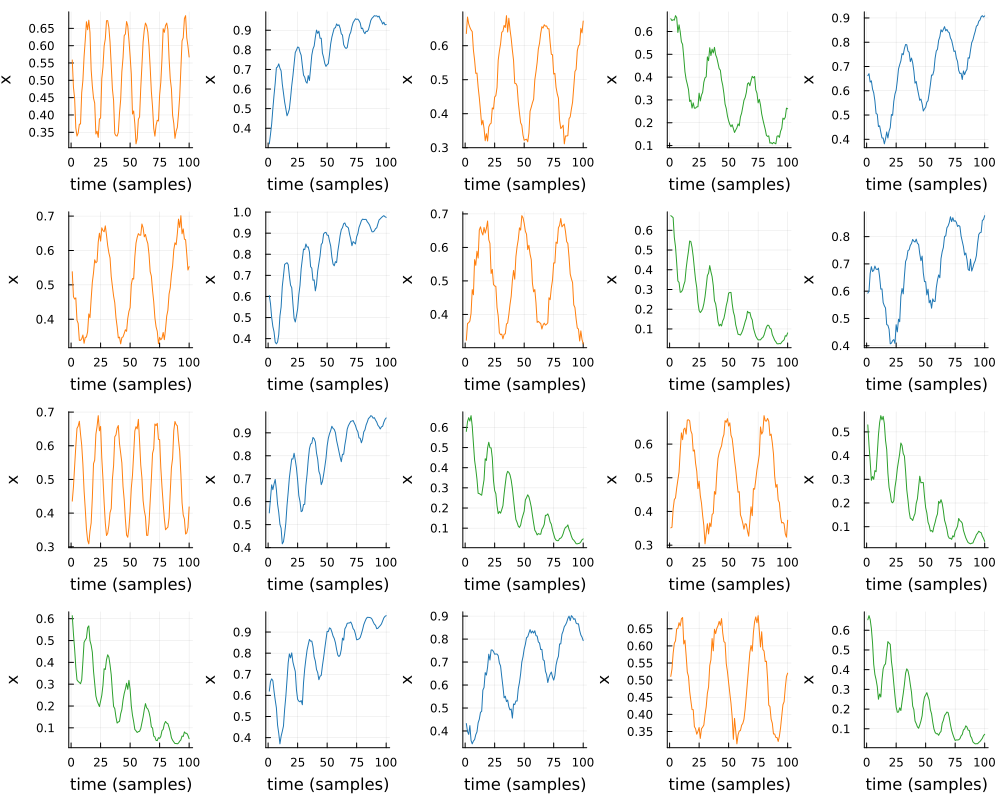

In [396]:
plot_idxs = sample(1:size(X_train, 1), 20)
ps = []
for pidx in plot_idxs
    trend = train_info["trend"][pidx]
    p = plot(rs_scaled[pidx, :], label="", xlabel="time (samples)", c=trend_map[trend], ylabel="x")
    push!(ps, p)
end
plot(ps..., size=(1000, 800))
#savefig("noisy_sine3_time_series_examples.svg")

In [399]:
#@save "low_noise3.jld2" X_train y_train X_test y_test

# Trial Two - High Noise Setting

In [405]:
function make_dataset2(num_train::Int, num_test::Int, 
    T::Int)

    train_matrix = Matrix{Float64}(undef, num_train, T)
    train_labels = Int.(zeros(num_train))
    test_matrix = Matrix{Float64}(undef, num_test, T)
    test_labels = Int.(zeros(num_test))


    phase_train = rand(Uniform(0, 2pi), num_train)
    phase_test = rand(Uniform(0, 2pi), num_test)
    sigma_train = fill(0.4, num_train)
    sigma_test = fill(0.4, num_test)
    freq_train = sample([3.0, 6.0], ProbabilityWeights([1/2, 1/2]), num_train)
    freq_test = sample([3.0, 6.0], ProbabilityWeights([1/2, 1/2]), num_test)
    trend_train = sample([-0.25, 0.0, 0.25], ProbabilityWeights([1/3, 1/3, 1/3]), num_train)
    trend_test = sample([-0.25, 0.0, 0.25], ProbabilityWeights([1/3, 1/3, 1/3]), num_test)
    train_info = Dict(
        "phase" => phase_train,
        "sigma" => sigma_train,
        "freq" => freq_train,
        "trend" => trend_train
    )
    test_info = Dict(
        "phase" => phase_test,
        "sigma" => sigma_test,
        "freq" => freq_test,
        "trend" => trend_test
    )
    
    for i in 1:num_train
        x = simulate_noisy_sine(100, freq_train[i], phase_train[i], trend_train[i], sigma_train[i])
        train_matrix[i, :] = x
    end

    for j in 1:num_test
        x = simulate_noisy_sine(100, freq_test[j], phase_test[j], trend_test[j], sigma_test[j])
        test_matrix[j, :] = x
    end

    X_train = train_matrix
    y_train = train_labels
    X_test = test_matrix
    y_test = test_labels

    return X_train, y_train, X_test, y_test, train_info, test_info

end

make_dataset2 (generic function with 1 method)

In [406]:
X_train, y_train, X_test, y_test, train_info, test_info = make_dataset2(1000, 200, 100)

([-1.2341549397691767 -0.9347873501857978 … 1.6705643265445314 0.8750365443154426; -0.04753856203393447 0.031506269180330504 … -0.38225479930871786 -0.4763185053354934; … ; 1.044967340447593 1.2149371372538649 … -3.6162230886943854 -3.687842951014594; -0.5818084063087491 -1.3652993292085962 … 0.14047216021660047 -0.8409904179192962], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-0.123509390884536 -0.7583758412549392 … -0.9087646848226734 -0.3754598943773815; -0.31649407653850925 0.16538709460119766 … -5.283309602908485 -5.338808649371629; … ; 0.34086775030871647 0.9744207000001163 … 0.3206877899337653 0.6614983365254666; -0.2934834140690654 -0.9297812399071907 … -5.6177691319782985 -5.84154584327068], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Dict("sigma" => [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4  …  0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], "phase" => [4.564755122645993, 6.2455066493004345, 2.122797829497084, 5.7384280966

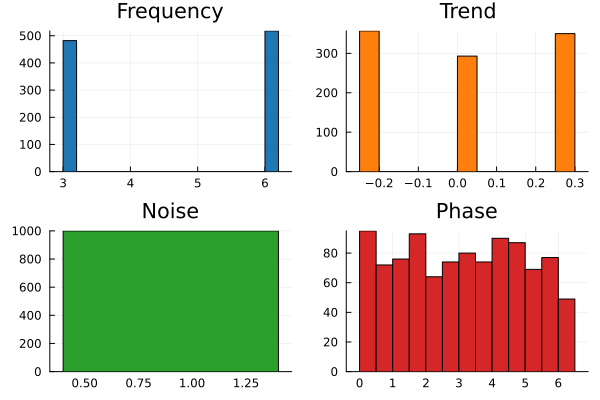

In [412]:
h1 = histogram(train_info["freq"], bins=20, label="", c=palette(:tab10)[1], title="Frequency")
h2 = histogram(train_info["trend"], bins=20, label="", c=palette(:tab10)[2], title="Trend")
h3 = histogram(train_info["sigma"], bins=20, label="", c=palette(:tab10)[3], title="Noise")
h4 = histogram(train_info["phase"], bins=20, label="", c=palette(:tab10)[4], title="Phase")
plot(h1, h2, h3, h4)
#savefig("noisy_sine_dist4.svg")

In [408]:
rs = RobustSigmoid(X_train)
rs_scaled = rs(X_train);

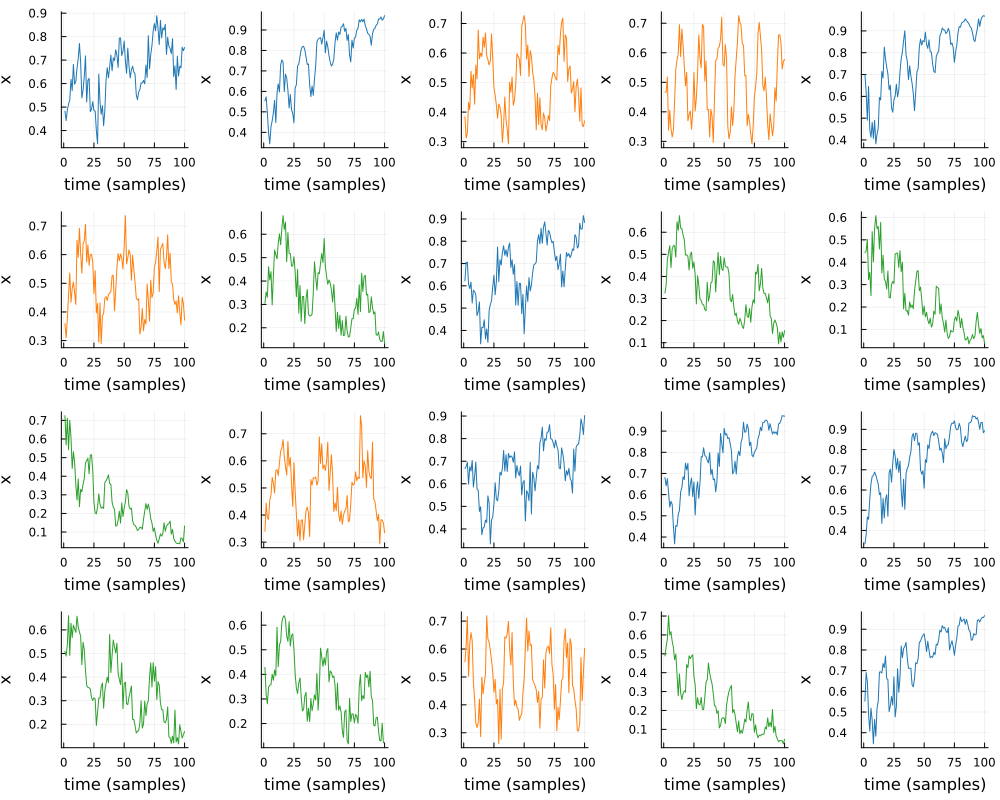

In [414]:
plot_idxs = sample(1:size(X_train, 1), 20)
ps = []
for pidx in plot_idxs
    trend = train_info["trend"][pidx]
    p = plot(rs_scaled[pidx, :], label="", xlabel="time (samples)", c=trend_map[trend], ylabel="x")
    push!(ps, p)
end
plot(ps..., size=(1000, 800))
#savefig("noisy_sine4_time_series_examples.svg")

In [410]:
@save "high_noise3.jld2" X_train y_train X_test y_test

# Trial 3 - Low Noise Setting, Additional Frequency 

In [416]:
function make_dataset3(num_train::Int, num_test::Int, 
    T::Int)

    train_matrix = Matrix{Float64}(undef, num_train, T)
    train_labels = Int.(zeros(num_train))
    test_matrix = Matrix{Float64}(undef, num_test, T)
    test_labels = Int.(zeros(num_test))


    phase_train = rand(Uniform(0, 2pi), num_train)
    phase_test = rand(Uniform(0, 2pi), num_test)
    sigma_train = fill(0.1, num_train)
    sigma_test = fill(0.1, num_test)
    freq_train = sample([2.0, 4.0, 6.0], ProbabilityWeights([1/3, 1/3, 1/3]), num_train)
    freq_test = sample([2.0, 4.0, 6.0], ProbabilityWeights([1/3, 1/3, 1/3]), num_test)
    trend_train = sample([-0.25, 0.0, 0.25], ProbabilityWeights([1/3, 1/3, 1/3]), num_train)
    trend_test = sample([-0.25, 0.0, 0.25], ProbabilityWeights([1/3, 1/3, 1/3]), num_test)
    train_info = Dict(
        "phase" => phase_train,
        "sigma" => sigma_train,
        "freq" => freq_train,
        "trend" => trend_train
    )
    test_info = Dict(
        "phase" => phase_test,
        "sigma" => sigma_test,
        "freq" => freq_test,
        "trend" => trend_test
    )
    
    for i in 1:num_train
        x = simulate_noisy_sine(100, freq_train[i], phase_train[i], trend_train[i], sigma_train[i])
        train_matrix[i, :] = x
    end

    for j in 1:num_test
        x = simulate_noisy_sine(100, freq_test[j], phase_test[j], trend_test[j], sigma_test[j])
        test_matrix[j, :] = x
    end

    X_train = train_matrix
    y_train = train_labels
    X_test = test_matrix
    y_test = test_labels

    return X_train, y_train, X_test, y_test, train_info, test_info

end

make_dataset3 (generic function with 1 method)

In [417]:
X_train, y_train, X_test, y_test, train_info, test_info = make_dataset3(1000, 200, 100)

([-0.7100846848855932 -0.26381865973829155 … -0.7559632558431444 -0.6678878931781574; 0.6299831402952988 0.43554209376035835 … 0.6051621024955491 0.7567433556069008; … ; -0.6569313517971507 -0.5995896481041557 … -2.0283652456261874 -2.101585293356221; 0.11548792260515721 0.01299919707328804 … 0.14331530473729964 0.08380771374119171], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-0.8925366809019067 -0.9668235925028758 … -4.058715192825423 -4.082490386484067; -0.7550126732188275 -0.8260149031774091 … -1.2593738786400155 -0.8526105476551503; … ; 0.6393177112943528 0.7036090915871245 … 0.8814149199169232 0.6022429752033609; 0.968534216479241 1.0700361081931042 … 5.41374161578981 5.602096715827607], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Dict("sigma" => [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], "phase" => [5.5387299096135765, 2.5381351587262935, 3.9286354703662787, 4.218349623158533

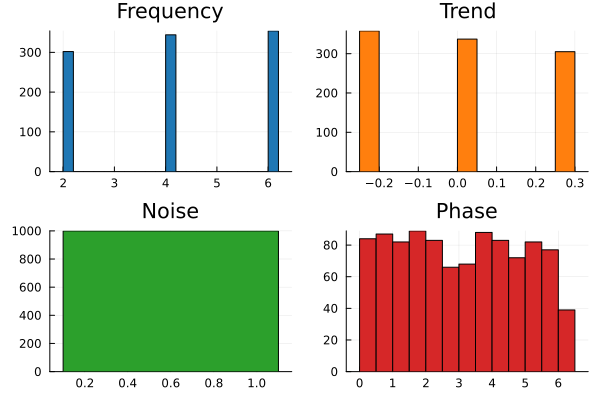

In [423]:
h1 = histogram(train_info["freq"], bins=20, label="", c=palette(:tab10)[1], title="Frequency")
h2 = histogram(train_info["trend"], bins=20, label="", c=palette(:tab10)[2], title="Trend")
h3 = histogram(train_info["sigma"], bins=20, label="", c=palette(:tab10)[3], title="Noise")
h4 = histogram(train_info["phase"], bins=20, label="", c=palette(:tab10)[4], title="Phase")
plot(h1, h2, h3, h4)
#savefig("noisy_sine_dist5.svg")

In [419]:
rs = RobustSigmoid(X_train)
rs_scaled = rs(X_train);

In [421]:
plot_idxs = sample(1:size(X_train, 1), 20)
ps = []
for pidx in plot_idxs
    trend = train_info["trend"][pidx]
    p = plot(rs_scaled[pidx, :], label="", xlabel="time (samples)", c=trend_map[trend], ylabel="x")
    push!(ps, p)
end
plot(ps..., size=(1000, 800))
#savefig("noisy_sine5_time_series_examples.svg")

"/Users/joshua/Desktop/QTNML_paper/QuantumInspiredML/Interpolation/paper/difficult-synthetic/v3/noisy_sine5_time_series_examples.svg"

In [424]:
#@save "low_noise_3freq.jld2" X_train y_train X_test y_test

# Trial 4 - High Noise Setting V2

In [425]:
function make_dataset4(num_train::Int, num_test::Int, 
    T::Int)

    train_matrix = Matrix{Float64}(undef, num_train, T)
    train_labels = Int.(zeros(num_train))
    test_matrix = Matrix{Float64}(undef, num_test, T)
    test_labels = Int.(zeros(num_test))


    phase_train = rand(Uniform(0, 2pi), num_train)
    phase_test = rand(Uniform(0, 2pi), num_test)
    sigma_train = fill(0.3, num_train)
    sigma_test = fill(0.3, num_test)
    freq_train = sample([3.0, 6.0], ProbabilityWeights([1/2, 1/2]), num_train)
    freq_test = sample([3.0, 6.0], ProbabilityWeights([1/2, 1/2]), num_test)
    trend_train = sample([-0.25, 0.0, 0.25], ProbabilityWeights([1/3, 1/3, 1/3]), num_train)
    trend_test = sample([-0.25, 0.0, 0.25], ProbabilityWeights([1/3, 1/3, 1/3]), num_test)
    train_info = Dict(
        "phase" => phase_train,
        "sigma" => sigma_train,
        "freq" => freq_train,
        "trend" => trend_train
    )
    test_info = Dict(
        "phase" => phase_test,
        "sigma" => sigma_test,
        "freq" => freq_test,
        "trend" => trend_test
    )
    
    for i in 1:num_train
        x = simulate_noisy_sine(100, freq_train[i], phase_train[i], trend_train[i], sigma_train[i])
        train_matrix[i, :] = x
    end

    for j in 1:num_test
        x = simulate_noisy_sine(100, freq_test[j], phase_test[j], trend_test[j], sigma_test[j])
        test_matrix[j, :] = x
    end

    X_train = train_matrix
    y_train = train_labels
    X_test = test_matrix
    y_test = test_labels

    return X_train, y_train, X_test, y_test, train_info, test_info

end

make_dataset4 (generic function with 1 method)

In [426]:
X_train, y_train, X_test, y_test, train_info, test_info = make_dataset4(1000, 200, 100)

([-1.1249809638076622 -0.4166660390627227 … -0.27233063497775734 -0.8995838317296694; 0.4497827173507805 0.9485611950369478 … -0.6613044224368269 0.3432784937639365; … ; -0.3642167689560153 -0.09378641186043593 … -3.089191036330847 -2.9815018330624037; -0.3997123410153831 -0.4722617137566867 … 0.4660289210205053 -0.729097505890348], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1.2079415819000268 1.0590318515232409 … 2.8608825009475876 3.2219542459737425; -0.8295858129505757 -0.365647922683763 … 1.8044273121749845 1.526889788530272; … ; 0.013405008741890746 0.09366964496401287 … -2.159866039690815 -1.930730462003909; -0.4313211175615304 -0.32013360624742143 … 3.6626814805979437 3.4393802827368476], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Dict("sigma" => [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3  …  0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3], "phase" => [5.579020972305762, 0.3019464044503366, 1.6931405332020746, 1.8143148895046

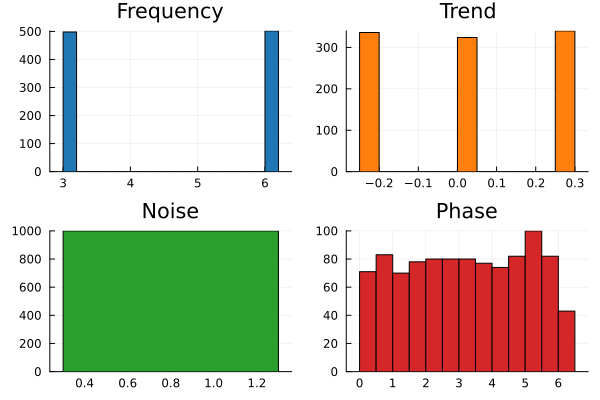

In [430]:
h1 = histogram(train_info["freq"], bins=20, label="", c=palette(:tab10)[1], title="Frequency")
h2 = histogram(train_info["trend"], bins=20, label="", c=palette(:tab10)[2], title="Trend")
h3 = histogram(train_info["sigma"], bins=20, label="", c=palette(:tab10)[3], title="Noise")
h4 = histogram(train_info["phase"], bins=20, label="", c=palette(:tab10)[4], title="Phase")
plot(h1, h2, h3, h4)
#savefig("noisy_sine_dist6.svg")

In [427]:
rs = RobustSigmoid(X_train)
rs_scaled = rs(X_train);

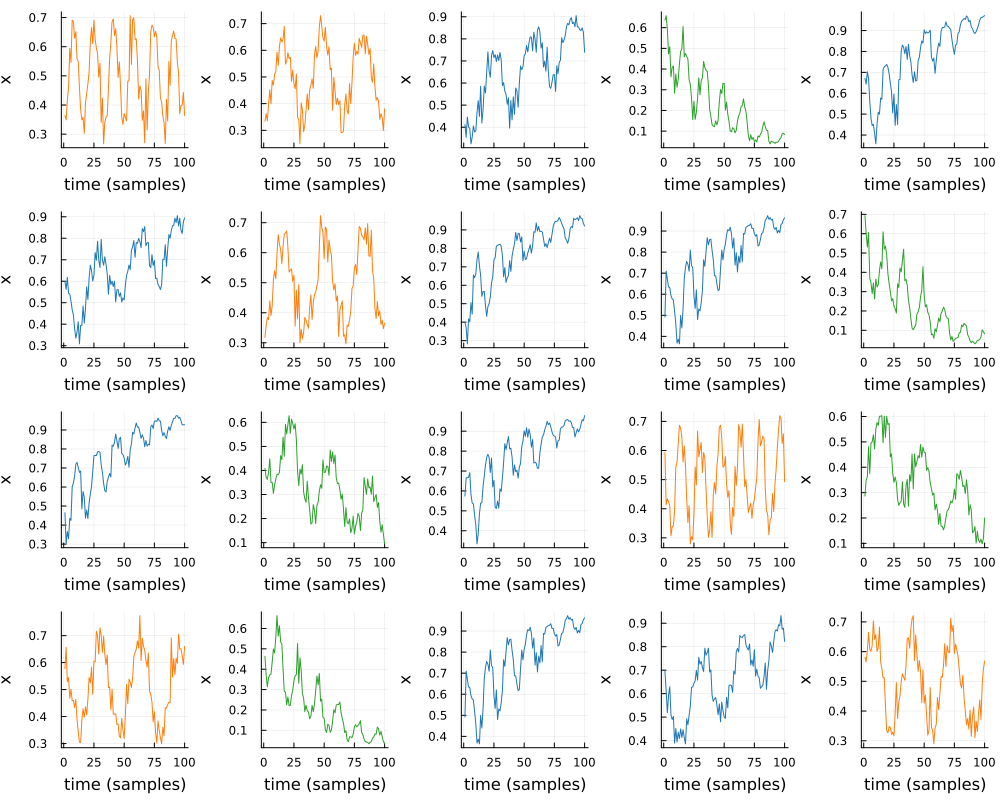

In [432]:
plot_idxs = sample(1:size(X_train, 1), 20)
ps = []
for pidx in plot_idxs
    trend = train_info["trend"][pidx]
    p = plot(rs_scaled[pidx, :], label="", xlabel="time (samples)", c=trend_map[trend], ylabel="x")
    push!(ps, p)
end
plot(ps..., size=(1000, 800))
#savefig("noisy_sine6_time_series_examples.svg")

In [434]:
#@save "high_noise_sig03.jld2" X_train y_train X_test y_test

# High Noise 3 freq

In [442]:
function make_dataset5(num_train::Int, num_test::Int, 
    T::Int)

    train_matrix = Matrix{Float64}(undef, num_train, T)
    train_labels = Int.(zeros(num_train))
    test_matrix = Matrix{Float64}(undef, num_test, T)
    test_labels = Int.(zeros(num_test))


    phase_train = rand(Uniform(0, 2pi), num_train)
    phase_test = rand(Uniform(0, 2pi), num_test)
    sigma_train = fill(0.2, num_train)
    sigma_test = fill(0.2, num_test)
    freq_train = sample([2.0, 4.0,  6.0], ProbabilityWeights([1/3, 1/3, 1/3]), num_train)
    freq_test = sample([2.0, 4.0, 6.0], ProbabilityWeights([1/3, 1/3, 1/3]), num_test)
    trend_train = sample([-0.25, 0.0, 0.25], ProbabilityWeights([1/3, 1/3, 1/3]), num_train)
    trend_test = sample([-0.25, 0.0, 0.25], ProbabilityWeights([1/3, 1/3, 1/3]), num_test)
    train_info = Dict(
        "phase" => phase_train,
        "sigma" => sigma_train,
        "freq" => freq_train,
        "trend" => trend_train
    )
    test_info = Dict(
        "phase" => phase_test,
        "sigma" => sigma_test,
        "freq" => freq_test,
        "trend" => trend_test
    )
    
    for i in 1:num_train
        x = simulate_noisy_sine(100, freq_train[i], phase_train[i], trend_train[i], sigma_train[i])
        train_matrix[i, :] = x
    end

    for j in 1:num_test
        x = simulate_noisy_sine(100, freq_test[j], phase_test[j], trend_test[j], sigma_test[j])
        test_matrix[j, :] = x
    end

    X_train = train_matrix
    y_train = train_labels
    X_test = test_matrix
    y_test = test_labels

    return X_train, y_train, X_test, y_test, train_info, test_info

end

make_dataset5 (generic function with 1 method)

In [444]:
X_train, y_train, X_test, y_test, train_info, test_info = make_dataset5(1000, 200, 100)

([-0.5787835435630132 -0.8347870782394783 … -2.1611488233803096 -2.639026199992138; 1.234630157062255 0.7423948822039625 … -3.512425565524702 -3.6316544567797155; … ; 0.9973711476292355 0.8209889166718612 … 0.4784846878439102 0.5091557467095198; -0.3202737293058266 -0.17953822855461005 … -2.050491104584435 -2.079212466398573], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-0.8120260620542219 -1.0482053386013466 … -5.332488754846764 -5.774891893223064; 0.6577578977904748 1.0360325645346395 … 0.942758503727475 0.8880705733744958; … ; 1.09383001618262 0.7193601808869619 … -2.0983137323580348 -2.2497534706939026; -0.6953606214906018 -0.5312356193260583 … -1.136479395258688 -0.901191969580426], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Dict("sigma" => [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2  …  0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], "phase" => [3.8139668586308653, 1.4522956501867705, 3.4352394582294843, 4.0558071107031655, 4.5

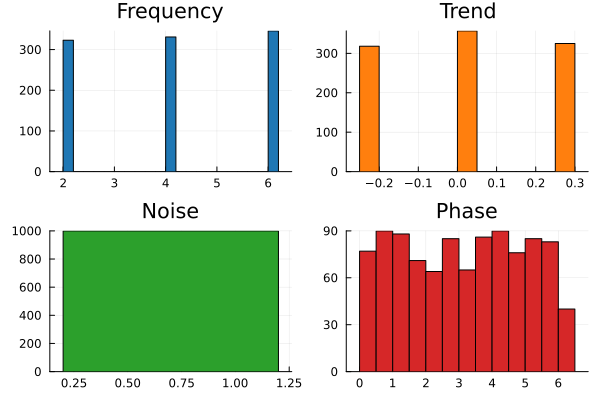

In [445]:
h1 = histogram(train_info["freq"], bins=20, label="", c=palette(:tab10)[1], title="Frequency")
h2 = histogram(train_info["trend"], bins=20, label="", c=palette(:tab10)[2], title="Trend")
h3 = histogram(train_info["sigma"], bins=20, label="", c=palette(:tab10)[3], title="Noise")
h4 = histogram(train_info["phase"], bins=20, label="", c=palette(:tab10)[4], title="Phase")
plot(h1, h2, h3, h4)
#savefig("noisy_sine_dist7.svg")

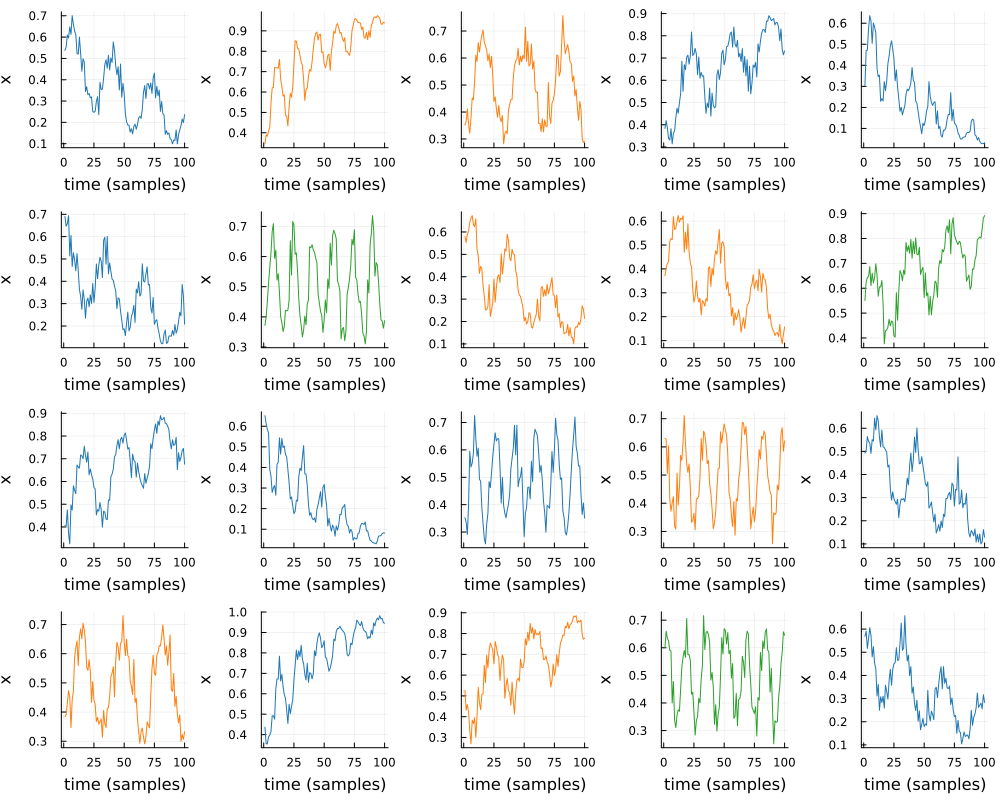

In [446]:
plot_idxs = sample(1:size(X_train, 1), 20)
ps = []
for pidx in plot_idxs
    trend = train_info["trend"][pidx]
    p = plot(rs_scaled[pidx, :], label="", xlabel="time (samples)", c=trend_map[trend], ylabel="x")
    push!(ps, p)
end
plot(ps..., size=(1000, 800))
#savefig("noisy_sine7_time_series_examples.svg")

In [449]:
#@save "high_noise_sig02_3freq.jld2" X_train y_train X_test y_test